# 3D Balance Ball

In this notebook, we will run the [3D Balance Ball example](https://github.com/Unity-Technologies/ml-agents/blob/main/docs/Learning-Environment-Examples.md#3dball-3d-balance-ball) from [Unity ML Agents](https://unity.com/products/machine-learning-agents). Please check the README file to setup this project.

### 1. Start the Environment

We begin by importing the necessary packages:

In [1]:
%load_ext autoreload
%autoreload 2
from my_unity_environment import MyUnityEnvironment
from model import Actor, Critic
from ddpg_agents import DDPGAgents
from ddpg_agent import DDPGAgent
from replay_buffer import ReplayBuffer
from utilities import convert_to_tensor
import numpy as np
import torch
import torch.nn.functional as f
import random
from collections import deque
import time
import matplotlib.pyplot as plt
%matplotlib inline

Next, we will start the environment. Before running the code cell below, change the `ENV_FILE_NAME` parameter to match the location of the Unity executable that you [downloaded](README.md) or [created](../README.md#creating-a-custom-unity-executable) yourself. For example:

```
ENV_FILE_NAME = "3DBall_Windows_x86_64/UnityEnvironment.exe"
```
A new window should pop up. Don't worry if the window becomes unresponsive.


In [2]:
ENV_FILE_NAME = "3DBall_Windows_x86_64/UnityEnvironment.exe"
CHECKPOINT_FILENAME = "checkpoint-3dball.pth" # this is used for saving and loading the model
DISPLAY_SIZE = [1024, 768] # The width and height of the Unity window

test_env = MyUnityEnvironment(file_name=ENV_FILE_NAME, no_graphics=False)
test_env.set_timescale(1.0)
test_env.set_display_size(width=DISPLAY_SIZE[0], height=DISPLAY_SIZE[1])

### 2. Examine the State and Action Spaces

In this environment, an agent must balance a ball on its head for as long as possible.

**Agent Reward Function:**
- +0.1 for every step the ball remains on its head.
- -1.0 if the ball falls off.

**Behavior Parameters:**
- Vector Observation space: 8 variables corresponding to rotation of the agent cube, and position and velocity of ball.
- Actions: 2 continuous actions, with one value corresponding to X-rotation, and the other to Z-rotation.

Run the code cell below to print some information about the environment:

In [3]:
def examine_environment(myenv: MyUnityEnvironment):
    # number of agents in the first behavior:
    print('Number of agents:', myenv.num_agents_list[0])

    # number of actions
    print('Size of each action:', myenv.behavior_specs[0].action_spec.continuous_size)

    # examine the state space
    print('States look like:', myenv.get_observations(0)[0])
    print('States have shape:', myenv.behavior_specs[0].observation_specs[0].shape)

examine_environment(test_env)

Number of agents: 1
Size of each action: 2
States look like: [-0.04766776 -0.08700117 -0.54295158  4.          0.11863136  0.
  0.          0.        ]
States have shape: (8,)


### 3. Take Random Actions in the Parallel Environment

Run the code cell below, to watch a random agent in action.

In [4]:
def test_random_agents(myenv: MyUnityEnvironment, n_episodes: int, max_t: int):
    start_time = time.time()
    for i in range(n_episodes):
        myenv.reset()
        scores = np.zeros(myenv.num_agents_list[0])
        for t in range(max_t):
            actions = np.random.randn(myenv.num_agents_list[0],
                                      myenv.behavior_specs[0].action_spec.continuous_size)
            actions = np.clip(actions, -1, 1)
            myenv.set_actions(behavior_index=0, continuous=actions)
            myenv.step()
            _, rewards, dones = myenv.get_experiences(behavior_index=0)
            scores += rewards.squeeze()
            if np.any(dones):
                break
        print('Score from episode {}: {}'.format(i, np.max(scores)))
    print(f"Time elapsed: {time.time() - start_time:.2f}")

test_random_agents(test_env, n_episodes=10, max_t=200)

Score from episode 0: 2.0000000447034836
Score from episode 1: 1.500000037252903
Score from episode 2: 2.400000050663948
Score from episode 3: 2.1000000461935997
Score from episode 4: 1.2000000327825546
Score from episode 5: 2.400000050663948
Score from episode 6: 1.0000000298023224
Score from episode 7: 1.8000000417232513
Score from episode 8: 1.1000000312924385
Score from episode 9: 1.1000000312924385
Time elapsed: 27.05


In [5]:
test_env.close()

### 4. Train the Agent with DDPG

Run the code cells below to train the agent from scratch.

Alternatively, you can skip to the next step below (**5. Watch a Smart Agent**), to load the saved model weights from a pre-trained agent.

In [6]:
class DDPGAgentsTester:
    def __init__(self, ddpg_agents: DDPGAgents,
                 myenv: MyUnityEnvironment,
                 buffer_size=int(1.0e6),  # replay buffer size
                 noise_start=1.0
                 ):
        self.ddpg_agents = ddpg_agents
        self.myenv = myenv
        self.buffer_size = buffer_size
        self.scores = []
        self.scores_deque = deque(maxlen=100)
        self.episode = 0
        self.noise = noise_start
        self.replay_buffer = ReplayBuffer(buffer_size)

    def train_agents(self, n_episodes, max_t, goal=float("inf"), print_every=1000, update_every=1,
                     num_updates=1, batch_size=64, noise_decay=6.93e-6):
        """ Multi Agent Deep Deterministic Policy Gradient algorithm.

        Params
        ======
            n_episodes (int): maximum number of training episodes
            max_t (int): maximum number of timesteps per episode
            goal (float): the algorithm will stop when the goal is reached
            print_every (int) : print intermediate results every %print_every episodes
            update_every (int): update the neural networks every %update_every time steps
            num_updates: How many updates to do in a row
            batch_size (int): minibatch size
            noise_decay (float): noise decay factor = 1.0 - %noise_decay
        """
        noise_decay = 1.0 - noise_decay
        start_episode = self.episode
        stop_episode = self.episode + n_episodes
        steps = 0
        start_time = time.time()
        last_print_time = 0
        for self.episode in range(start_episode, stop_episode):
            score = np.zeros(len(self.ddpg_agents))
            self.myenv.reset()
            states = self.myenv.get_observations(behavior_index=0)
            for t in range(max_t):
                steps += 1
                # get actions from all agents:
                actions = self.ddpg_agents.act(convert_to_tensor(states[:, np.newaxis, :]), self.noise)
                # remove batch_size from actions:
                actions = actions[:, 0, :]
                self.myenv.set_actions(behavior_index=0, continuous=actions)
                self.myenv.step()
                next_states, rewards, dones = self.myenv.get_experiences(behavior_index=0)

                # add sample to replay buffer:
                sample = (states, actions, rewards, next_states, dones)
                self.replay_buffer.add(sample)

                states = next_states
                self.noise *= noise_decay
                score += rewards.squeeze()

                # update networks every %update_every time steps:
                if steps % update_every == 0 and len(self.replay_buffer) > batch_size * 100:
                    for _ in range(num_updates):
                        samples = [self.replay_buffer.sample(batch_size) for _ in range(len(self.ddpg_agents))]
                        self.ddpg_agents.step(samples)
                        #soft update the target network towards the actual networks:
                        self.ddpg_agents.update_target_networks()

                if np.any(dones):  # exit loop if episode finished
                    break

            self.scores_deque.append(score)
            self.scores.append(score)

            average_scores = np.mean(self.scores_deque, 0)  # average score over last 100 episodes for each agent
            if time.time() - last_print_time > 1.0:
                time_per_step = (time.time() - start_time) / steps
                print('\rEpisode {}\tSteps: {}\tTime per step: {:.6f}\tAverage Scores: {:.3f}'
                      .format(self.episode, steps, time_per_step, *average_scores), end="")
                last_print_time = time.time()
            if self.episode % print_every == 0:
                print("\r" + " " * 80, end="")
                print('\rEpisode {}\tAverage Scores: {:.3f}'.format(self.episode, *average_scores))
            if len(self.scores) >= print_every and np.max(average_scores) >= goal:
                print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}\tTime elapsed: {}'.format(
                    self.episode, np.max(average_scores), time.time() - start_time))
                break

    def test_agent(self, n_episodes, max_t):
        for _ in range(n_episodes):
            self.myenv.reset()
            states = self.myenv.get_observations(behavior_index=0)
            score = np.zeros(len(self.ddpg_agents))
            for _ in range(max_t):
                # get actions from all agents:
                actions = self.ddpg_agents.act(convert_to_tensor(states[:, np.newaxis, :]), noise_scale=0.0)
                # remove batch_size from actions:
                actions = actions[:, 0, :]

                self.myenv.set_actions(behavior_index=0, continuous=actions)
                self.myenv.step()
                next_states, rewards, dones = self.myenv.get_experiences(behavior_index=0)

                score += rewards.squeeze()
                states = next_states
                if np.any(dones):  # exit loop if episode finished
                    break
            print("Score: {}".format(score))

In [7]:
random_seed = 1
np.random.seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)
train_env = MyUnityEnvironment(file_name=ENV_FILE_NAME, seed=random_seed, no_graphics=True, worker_id=0)
train_env.set_timescale(time_scale=100.0)

In [8]:
actor1 = Actor(state_size=8, action_size=2, hidden_layer_sizes=[400, 300], activation_func=f.leaky_relu)
critic1 = Critic(state_size=8, action_size=2, hidden_layer_sizes=[400, 300], activation_func=f.leaky_relu,
                 inject_layer=0)
ddpg_agent1 = DDPGAgent(actor1, critic1, gamma=0.99, tau=1.0e-3, lr_actor=1.0e-4, lr_critic=1.0e-3, weight_decay=1.0e-2)
ddpg_agent_list = [ddpg_agent1]
ddpg_agents = DDPGAgents(ddpg_agent_list)
ddpg_agents_tester = DDPGAgentsTester(ddpg_agents, train_env, buffer_size=int(1.0e6), noise_start=1.0)

You can skip this cell, if you don’t want to train the agent from scratch. It may take 30 to 45 minutes:

In [9]:
ddpg_agents_tester.myenv = train_env
ddpg_agents_tester.train_agents(n_episodes=int(1.0e5), max_t=100, goal=10.0, update_every=1,
                                num_updates=1, batch_size=64, noise_decay=6.93e-6)
ddpg_agents.save_checkpoint(filename=CHECKPOINT_FILENAME)

Episode 0	Average Scores: 1.500                                                 
Episode 1000	Average Scores: 0.854                                              
Episode 2000	Average Scores: 0.710                                              
Episode 3000	Average Scores: 0.829                                              
Episode 4000	Average Scores: 1.844                                              
Episode 5000	Average Scores: 2.710                                              
Episode 6000	Average Scores: 3.985                                              
Episode 6301	Steps: 182838	Time per step: 0.011439	Average Scores: 10.000
Environment solved in 6301 episodes!	Average Score: 10.00	Time elapsed: 2091.4249007701874


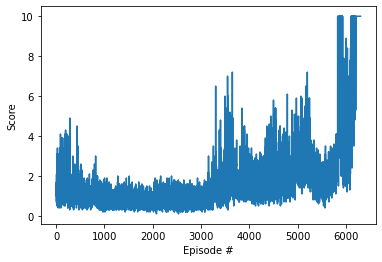

In [10]:
def plot_scores():
    scores = np.vstack(ddpg_agents_tester.scores)
    scores = np.max(scores, 1)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(1, len(scores) + 1), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

plot_scores()

### 5. Watch a Smart Agent

In [11]:
test_env = MyUnityEnvironment(file_name=ENV_FILE_NAME, worker_id=1)
test_env.set_timescale(1.0)
test_env.set_display_size(width=DISPLAY_SIZE[0], height=DISPLAY_SIZE[1])
ddpg_agents_tester.myenv = test_env
ddpg_agents.load_checkpoint(filename=CHECKPOINT_FILENAME)

In [12]:
ddpg_agents_tester.test_agent(n_episodes=10, max_t=200)

Score: [20.0000003]
Score: [20.0000003]
Score: [20.0000003]
Score: [20.0000003]
Score: [20.0000003]
Score: [20.0000003]
Score: [20.0000003]
Score: [20.0000003]
Score: [20.0000003]
Score: [20.0000003]


When finished, you can close the environment.

In [13]:
train_env.close()
test_env.close()